1. 데이터 탐색 및 전처리 (EDA)
- Customers , atticles, transactions 데이터 merge 결합
- 결측치를 확인 및 0으로 처리하고 날짜 형식 맞추기

In [ ]:
# Loaded variable 'df' from URI: c:\Users\urina\OneDrive\Desktop\기초 프로젝트\h&m dataset\articles_hm.csv
import pandas as pd
import matplotlib as plt
import seaborn as sns
import numpy as np
df_articles = pd.read_csv(r'c:\Users\urina\OneDrive\Desktop\기초 프로젝트\h&m dataset\articles_hm.csv')
df_cust = pd.read_csv(r'c:\Users\urina\OneDrive\Desktop\기초 프로젝트\h&m dataset\customer_hm.csv')
df_trans = pd.read_csv(r'C:\Users\urina\OneDrive\Desktop\기초 프로젝트\h&m dataset\transactions_hm.csv') 

In [ ]:
# 필요한 컬럼만 골라서 병합 
# Transactions + Customers
df_merged = pd.merge(df_trans[['t_dat', 'customer_id', 'article_id']], 
                     df_cust[['customer_id', 'age']], 
                     on='customer_id', 
                     how='inner') 

# + Articles
df_merged = pd.merge(df_merged, 
                     df_articles[['article_id', 'prod_name', 'product_group_name', 'detail_desc']], 
                     on='article_id', 
                     how='inner')

print("데이터 합치기 완료!")
print(df_merged.head())


데이터 합치기 완료!
        t_dat                                        customer_id  article_id  \
0  2019-11-05  3e2b60b679e62fb49516105b975560082922011dd752ec...   698328010   
1  2019-05-22  89647ac2274f54c770aaa4b326e0eea09610c252381f37...   760597002   
2  2019-05-10  2ebe392150feb60ca89caa8eff6c08b7ef1138cd6fdc71...   488561032   
3  2019-08-26  7b3205de4ca17a339624eb5e3086698e9984eba6b47c56...   682771001   
4  2019-08-10  3b77905de8b32045f08cedb79200cdfa477e9562429a39...   742400033   

   age        prod_name  product_group_name  \
0   51     ZEBRA CF TVP  Garment Upper body   
1   28  BUBBLE WRAP TOP  Garment Upper body   
2   37    Teddy jogger.  Garment Lower body   
3   19     Yuki shopper         Accessories   
4   35    1pk Sportsock      Socks & Tights   

                                         detail_desc  
0  Top in lightweight sweatshirt fabric with drop...  
1  Short-sleeved blouse in stretch, textured jers...  
2  Knee-length shorts in soft washed cotton with ...  
3  S

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

# 1. 나이 구간 정의
# 0~15세, 16~24세, 25~34세, 35세 이상
bins = [0, 15, 24, 34, 100]
labels = ['Under 16', '16-24', '25-34', '35+']

# 2. 나이 그룹핑
df_cust['age_group_hm'] = pd.cut(df_cust['age'], bins=bins, labels=labels)

# 3. 그룹별 인원수 확인
group_counts = df_cust['age_group_hm'].value_counts().sort_index()
print(group_counts)

age_group_hm
Under 16         0
16-24       276631
25-34       304493
35+         467451
Name: count, dtype: int64


C:\Users\urina\AppData\Local\Temp\ipykernel_30404\3517495873.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='age_group_hm', data=df_cust, palette='pastel')


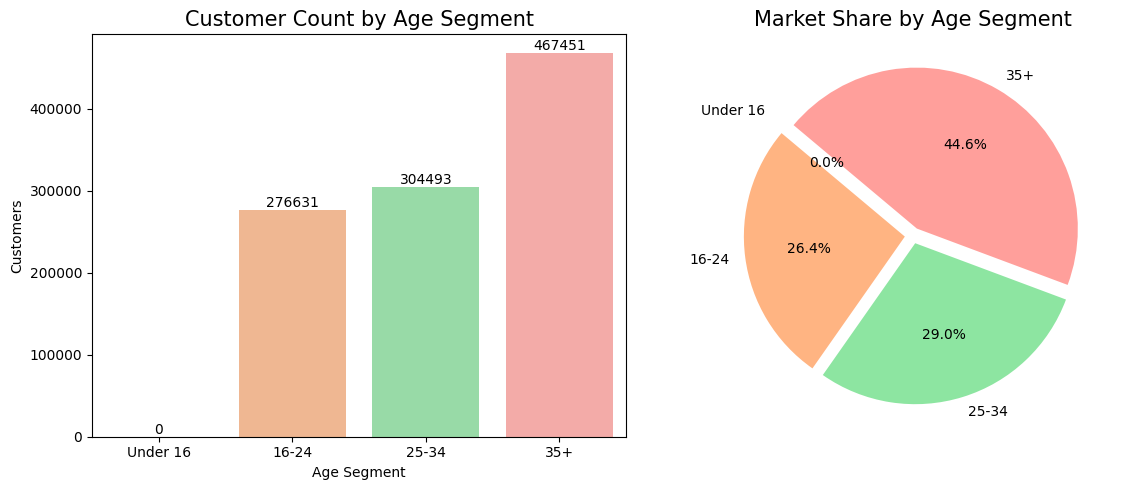

In [81]:
# 그래프 크기 설정
plt.figure(figsize=(12, 5))

# --- 1. 막대 그래프: 인원수 비교 ---
plt.subplot(1, 2, 1) 
sns.countplot(x='age_group_hm', data=df_cust, palette='pastel')
plt.title("Customer Count by Age Segment", fontsize=15)
plt.xlabel("Age Segment")
plt.ylabel("Customers")

# 각 막대 위에 숫자 표시하기 
for i, count in enumerate(group_counts):
    plt.text(i, count, str(count), ha='center', va='bottom')


# --- 2. 파이 차트 비교 ---
plt.subplot(1, 2, 2) 
plt.pie(group_counts, 
        labels=group_counts.index, 
        autopct='%1.1f%%', # 소수점 1자리까지 % 표시
        startangle=140, 
        colors=sns.color_palette('pastel'),
        explode=[0.1, 0.05, 0.05, 0.05]) # 첫 번째 조각 살짝 떼어내기 (강조?)
 
plt.title("Market Share by Age Segment", fontsize=15)

plt.tight_layout() # 그래프 간격 자동 조절
plt.show()

연령대를 이런식으로 나눠보니 해당 데이터에는 16세 이하의 고객이 없고 
16 - 34 사이의 고객이 총 매출의 55% 를 차지하며, 35세 이상 고객이 총 매출의 44%를 차지하고 있는것을 알 수 있었습니다.
그래서 해당 두가지의 그룹을 핵심 타겟으로 맞춤형 세트 제품을 기획했습니다.

테이블에 성별을 나타내는 컬럼이 없고, index_group 컬럼에 ladies, men 등 행의 이름으로 분류를 해야하는 상황

그래서 '고객이 어떤 성별인지' 가 아니라 '어떤 성별의 제품을 가장 많이 사는가?' 를 그 고객의 성별(또는 선호 그룹)으로 정의

- A 고객이 ladieswear 5개 , menswear 1개를 샀다면 => Ladies로 분류하는 식

In [ ]:
import pandas as pd

# 1. 필요한 데이터 합치기 (거래 내역 + 상품 대분류)
df_gender_base = pd.merge(df_trans[['customer_id', 'article_id']], 
                          df_articles[['article_id', 'index_group_name']], 
                          on='article_id', 
                          how='left')

# 2. 고객별로 각 카테고리를 몇 개 샀는지 세기
# crosstab: 교차표를 만들어줍니다. (행: 고객ID, 열: 카테고리)
category_counts = pd.crosstab(df_gender_base['customer_id'], df_gender_base['index_group_name'])

# 3. 가장 많이 산 카테고리(idxmax) 뽑기 -> 이것을 '추정 성별'로 사용
# axis=1 : 가로 방향(열) 중에서 최댓값을 찾음
predicted_gender = category_counts.idxmax(axis=1).reset_index()
predicted_gender.columns = ['customer_id', 'predicted_group']

# 결과 확인
print("--- 고객별 선호 성별/그룹 추론 결과 ---")
print(predicted_gender['predicted_group'].value_counts())
print(predicted_gender.head())

--- 고객별 선호 성별/그룹 추론 결과 ---
predicted_group
Ladieswear       294770
Divided          114885
Baby/Children     19016
Menswear          18105
Sport             11459
Name: count, dtype: int64
                                         customer_id predicted_group
0  00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...      Ladieswear
1  0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...      Ladieswear
2  000064249685c11552da43ef22a5030f35a147f723d5b0...           Sport
3  0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d...      Ladieswear
4  00007d2de826758b65a93dd24ce629ed66842531df6699...      Ladieswear


R : 최근 구매일로부터 며칠 지났는지 
F : 구매 횟수 
M : 총 구매 금액

In [ ]:
# 기준 날짜 정하기 
latest_date = df_trans['t_dat'].max() + pd.Timedelta(days=1)

# 고객별 RFM 계산 
rfm = df_trans.groupby('customer_id').agg({
    't_dat': lambda x: (latest_date - x.max()).days, 
    'article_id': 'count',                          
    'price': 'sum'                                   
})

# 컬럼 이름 변경
rfm.rename(columns={'t_dat': 'Recency', 
                    'article_id': 'Frequency', 
                    'price': 'Monetary'}, inplace=True)

# --- 행동 세그먼트 정의 예시 ---

# 1. VIP 고객 (자주 사고, 많이 쓰는 사람)
# (상위 20% 기준 등으로 자를 수 있습니다)
top_20_amount = rfm['Monetary'].quantile(0.8)
rfm['is_vip'] = rfm['Monetary'] >= top_20_amount

# 2. 휴면 위험 고객 (구매한 지 100일이 넘은 사람)
rfm['is_dormant'] = rfm['Recency'] > 100

print(rfm.head())

TypeError: can only concatenate str (not "Timedelta") to str

In [79]:
# 결측치(NaN) 
print('--- 처리 전 결측치 개수---')
print(df_customers.isnull().sum())

# FN / ACTIVE 비어있다 = '활동안함 / 구독안함' 즉, 0으로 채움 
df_customers['FN'] = df_customers['FN'].fillna(0)
df_customers['Active'] = df_customers['Active'].fillna(0) 

# 채워졌는지 확인
print('\n--- 처리 후 결측치 개수 ---')
print(df_customers.isnull().sum())

--- 처리 전 결측치 개수---
customer_id               0
FN                        0
Active                    0
club_member_status        0
fashion_news_frequency    1
age                       0
dtype: int64

--- 처리 후 결측치 개수 ---
customer_id               0
FN                        0
Active                    0
club_member_status        0
fashion_news_frequency    1
age                       0
dtype: int64


In [62]:
# 같은 고객(customer_id)이 같은 날(t_dat)에 산 내역끼리 붙이기
# suffixes: 이름이 같은 컬럼(prod_name 등)이 충돌할 때 꼬리표를 붙여줍니다.
df_sets = pd.merge(df_tops, df_bottoms, 
                   on=['customer_id', 't_dat'], 
                   how='inner', 
                   suffixes=('_top', '_bottom'))

print(f"찾아낸 상의+하의 세트 구매 조합: {len(df_sets)}건")
# 결과 예시: (날짜, 고객ID, 후드티_top, 청바지_bottom) 이런 데이터가 생성됩니다.

찾아낸 상의+하의 세트 구매 조합: 10351건


In [63]:
# 상의 이름 + 하의 이름 조합의 개수를 셉니다.
top_bottom_counts = df_sets.groupby(['prod_name_top', 'prod_name_bottom']).size().reset_index(name='count')

# 판매량이 많은 순서대로 정렬 (Top 10)
best_sets = top_bottom_counts.sort_values(by='count', ascending=False).head(10)

print("--- 20대가 가장 많이 산 [상의 + 하의] 조합 TOP 10 ---")
print(best_sets)

--- 20대가 가장 많이 산 [상의 + 하의] 조합 TOP 10 ---
          prod_name_top           prod_name_bottom  count
301          Anita Tank  RA RW shorts conscious(1)      9
5731    Mariette Blazer         Hayes slim trouser      7
2292  DIANA BRALETT S.0                 MAYA SKIRT      6
7891         SPEEDY TEE             SUPREME tights      6
8976     Tory price tee          SUPREME RW tights      6
2547          Despacito             Luna skinny RW      5
1214        Brittany LS   Jade HW Skinny Denim TRS      5
5736    Mariette Blazer            Kanta slacks RW      5
8238    Sirpa Basic TVP   Jade HW Skinny Denim TRS      5
8853          Tilly (1)             Skirt Mini Bea      5


In [ ]:
# (전제: best_sets DataFrame이 메모리에 존재하고, 20대만 필터링한 결과라고 가정)

age_group = "20" # 필터링한 연령대 20대

print("--- 🛍️ 구매 경향 분석 결과 (TOP 10) ---")

# iterrows()를 사용해 best_sets의 행을 하나씩 순회하기
for index, row in best_sets.iterrows():
    
    # 딕셔너리처럼 컬럼의 값을 가져오기
    top_item = row['prod_name_top']
    bottom_item = row['prod_name_bottom']
    count = row['count']
    
    # f-string을 사용하여 컬럼 값을 문장 안에 대입함
    insight_sentence = (
        f"데이터 분석 결과, {age_group}대 고객은 '{top_item}'을 살 때, "
        f"'{bottom_item}'를 같이 구매하는 경향이 가장 강했습니다. (총 {count}건)"
    )
    
    print(insight_sentence)
    print("-" * 50) 

# 이 코드를 실행하면, 데이터프레임의 모든 행이 보고서 형식의 문장으로 변환되어 출력함

--- 🛍️ 구매 경향 분석 결과 (TOP 10) ---
데이터 분석 결과, 20대 고객은 'Anita Tank'을 살 때, 'RA RW shorts conscious(1)'를 같이 구매하는 경향이 가장 강했습니다. (총 9건)
--------------------------------------------------
데이터 분석 결과, 20대 고객은 'Mariette Blazer'을 살 때, 'Hayes slim trouser'를 같이 구매하는 경향이 가장 강했습니다. (총 7건)
--------------------------------------------------
데이터 분석 결과, 20대 고객은 'DIANA BRALETT S.0'을 살 때, 'MAYA SKIRT'를 같이 구매하는 경향이 가장 강했습니다. (총 6건)
--------------------------------------------------
데이터 분석 결과, 20대 고객은 'SPEEDY TEE'을 살 때, 'SUPREME tights'를 같이 구매하는 경향이 가장 강했습니다. (총 6건)
--------------------------------------------------
데이터 분석 결과, 20대 고객은 'Tory price tee'을 살 때, 'SUPREME RW tights'를 같이 구매하는 경향이 가장 강했습니다. (총 6건)
--------------------------------------------------
데이터 분석 결과, 20대 고객은 'Despacito'을 살 때, 'Luna skinny RW'를 같이 구매하는 경향이 가장 강했습니다. (총 5건)
--------------------------------------------------
데이터 분석 결과, 20대 고객은 'Brittany LS'을 살 때, 'Jade HW Skinny Denim TRS'를 같이 구매하는 경향이 가장 강했습니다. (총 5건)
---------------------------

데이터 분석 결과, 20대 고객은 ''을 살 때 '제깅스'를 같이 구매하는 경향이 가장 강했습니다. (150건) 따라서 이 두 상품을 묶어서' 썸머 페스티벌 룩' 으로 기획하고 메인페이지에 노출 할 것을 제안합니다.

2. 고객 세그먼트 정의 
- 연령대별
- 선호 부서별

In [66]:
# 함수 정의: 연령대 문자열과 분석 결과를 입력받습니다.
def generate_sets_report(segment_name, top_sets_df):
    
    print(f"\n--- 🛍️ {segment_name} 고객의 베스트 조합 보고서 ---")
    
    # iterrows()를 사용해 DataFrame을 행 단위로 순회합니다.
    for index, row in top_sets_df.iterrows():
        
        top_item = row['prod_name_top']
        bottom_item = row['prod_name_bottom']
        count = row['count']
        
        # f-string에 'segment_name' 변수를 대입합니다.
        insight_sentence = (
            f"데이터 분석 결과, {segment_name} 고객은 '{top_item}'을 살 때, "
            f"'{bottom_item}'를 같이 구매하는 경향이 가장 강했습니다. (총 {count}건)"
        )
        
        print(insight_sentence)
        print("-" * 60)

# --- 함수 사용 예시 ---

# 1. '20대' 분석 결과를 보고서로 생성
# best_sets는 이전 단계에서 구한 DataFrame이라고 가정합니다.
generate_sets_report("30대", best_sets) 

# 2. 만약 나중에 '30대' 분석 결과를 구했다면, 이렇게 호출합니다.
# generate_sets_report("30대", best_sets_30s)


--- 🛍️ 30대 고객의 베스트 조합 보고서 ---
데이터 분석 결과, 30대 고객은 'Anita Tank'을 살 때, 'RA RW shorts conscious(1)'를 같이 구매하는 경향이 가장 강했습니다. (총 9건)
------------------------------------------------------------
데이터 분석 결과, 30대 고객은 'Mariette Blazer'을 살 때, 'Hayes slim trouser'를 같이 구매하는 경향이 가장 강했습니다. (총 7건)
------------------------------------------------------------
데이터 분석 결과, 30대 고객은 'DIANA BRALETT S.0'을 살 때, 'MAYA SKIRT'를 같이 구매하는 경향이 가장 강했습니다. (총 6건)
------------------------------------------------------------
데이터 분석 결과, 30대 고객은 'SPEEDY TEE'을 살 때, 'SUPREME tights'를 같이 구매하는 경향이 가장 강했습니다. (총 6건)
------------------------------------------------------------
데이터 분석 결과, 30대 고객은 'Tory price tee'을 살 때, 'SUPREME RW tights'를 같이 구매하는 경향이 가장 강했습니다. (총 6건)
------------------------------------------------------------
데이터 분석 결과, 30대 고객은 'Despacito'을 살 때, 'Luna skinny RW'를 같이 구매하는 경향이 가장 강했습니다. (총 5건)
------------------------------------------------------------
데이터 분석 결과, 30대 고객은 'Brittany LS'을 살 때, 'Jade HW Skinny Denim TRS

3. 장바구니 분석
- 각 그룹 별 같은 날짜 (t_dat), 같은 고객(customer_id) 이 무엇을 같이 샀는지 
- 가장 많이 등장하는 [상품A + 상품B] 조합 5개 뽑아보기